# "Hot Hand" Analysis Using NBA Shot Charts

In this notebook, I outline the process of performing "hot hand" analysis on a single game of Steph Curry's before automating the process to analyze every game in a season in one go.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import urllib.request
from bs4 import BeautifulSoup

---
## Retrieving one of Curry's shot strings for a single game

In [2]:
# Send a get request and assign the response to a variable
response = requests.get(f'https://www.basketball-reference.com/boxscores/shot-chart/202104190PHI.html')

# Turn the undecoded content into a Beautiful Soup object and assign it to a variable
soup = BeautifulSoup(response.content, 'html.parser')  

# Scrape makes and misses by quarter
q1makes = soup.find_all(class_='tooltip q-1 p-curryst01 make')
q1misses = soup.find_all(class_='tooltip q-1 p-curryst01 miss')
q2makes = soup.find_all(class_='tooltip q-2 p-curryst01 make')
q2misses = soup.find_all(class_='tooltip q-2 p-curryst01 miss')
q3makes = soup.find_all(class_='tooltip q-3 p-curryst01 make')
q3misses = soup.find_all(class_='tooltip q-3 p-curryst01 miss')
q4makes = soup.find_all(class_='tooltip q-4 p-curryst01 make')
q4misses = soup.find_all(class_='tooltip q-4 p-curryst01 miss')

# Potential OT too
q5makes = soup.find_all(class_='tooltip q-5 p-curryst01 make')
q5misses = soup.find_all(class_='tooltip q-5 p-curryst01 miss')
q6makes = soup.find_all(class_='tooltip q-6 p-curryst01 make')
q6misses = soup.find_all(class_='tooltip q-6 p-curryst01 miss')

# Add html from above to list and convert to string
shot_list = list(q1makes+q2makes+q3makes+q4makes+q5makes+q6makes+q1misses+q2misses+q3misses+q4misses+q5misses+q6misses)
shot_list = [str(item) for item in shot_list]

# Store list in dataframe
shot_df = pd.DataFrame(data=shot_list)

# Split string on space to form new columns
shot_df = shot_df[0].str.split(" ",expand=True)

# Select and name remaing useful columns from this split
shot_df = shot_df.loc[:,(2,8,11)]
shot_df.columns = ['quarter','time','outcome']

# Format quarter as integer
shot_df['quarter'] = shot_df['quarter'].str.slice(start=2).astype(int)

# Separate time into component parts and total as 'time_remaining_secs'
shot_df['minutes_remaining'] = shot_df['time'].str.split(":", expand=True).drop(columns=1).astype(int)
shot_df['seconds_remaining'] = shot_df['time'].str.split(":", expand=True).drop(columns=0)
shot_df['seconds_remaining'] = shot_df['seconds_remaining'].str.slice(stop=-2).astype(int)
shot_df['time_remaining_secs'] = shot_df['minutes_remaining']*60+shot_df['seconds_remaining']
shot_df = shot_df.drop(columns= ['time', 'minutes_remaining', 'seconds_remaining'])

# Sort shots in ascending order
shot_df = shot_df.sort_values(by=['quarter','time_remaining_secs'], ascending=[True, False]).reset_index().drop(columns=['index'])

# Convert 'outcome' to binary
shot_df['outcome'] = shot_df['outcome'].replace('made',1)
shot_df['outcome'] = shot_df['outcome'].replace('missed',0).astype(int)
shot_df

,quarter,outcome,time_remaining_secs
0,1,0,655
1,1,0,606
2,1,1,329
3,1,1,305
4,1,0,148
5,1,1,104
6,1,0,40
7,1,1,0
8,2,1,304
9,2,1,241


---
## Identifying shots following a single make or miss

In [3]:
# Create new column 'follows_make' that identifies shots following a made shot
shot_df['follows_make'] = shot_df['outcome'].shift()
shot_df['follows_make'] = shot_df['follows_make'].replace(np.nan,0).astype(int)

display(shot_df)

# Calculate conditional fraction of makes following a make
if sum(shot_df['follows_make'])>0:
    print(f"Following a make: {sum(shot_df[shot_df['follows_make']==1]['outcome'])} out of \
{sum(shot_df['follows_make'])} ({round(sum(shot_df[shot_df['follows_make']==1]['outcome'])/sum(shot_df['follows_make']),4)*100}%)")
else:
    print('Following a make: 0 out of 0 (0.0%)')
    
# Calculate conditional fraction of makes following a miss
print(f"Following a miss: {sum(shot_df[shot_df['follows_make']==0]['outcome'][1:])} out of \
{(len(shot_df['follows_make'])-sum(shot_df['follows_make'])-1)} \
({round(sum(shot_df[shot_df['follows_make']==0]['outcome'][1:])/(len(shot_df['follows_make'])-sum(shot_df['follows_make'])-1),4)*100}%)")

# Subtract conditional fractions to give test statistic
print(f"Test statistic: \
{round(sum(shot_df[shot_df['follows_make']==1]['outcome'])/sum(shot_df['follows_make'])-sum(shot_df[shot_df['follows_make']==0]['outcome'][1:])/(len(shot_df['follows_make'])-sum(shot_df['follows_make'])-1),4)*100}%")

,quarter,outcome,time_remaining_secs,follows_make
0,1,0,655,0
1,1,0,606,0
2,1,1,329,0
3,1,1,305,1
4,1,0,148,1
5,1,1,104,0
6,1,0,40,1
7,1,1,0,0
8,2,1,304,1
9,2,1,241,1


Following a make: 8 out of 13 (61.53999999999999%)
Following a miss: 6 out of 14 (42.86%)
Test statistic: 18.68%


---
## Comparing this string to 10,000 random permutations of itself

In [4]:
import random

# Placeholder list for test statistics
score = []

# Convert shot string to list
outcome = shot_df['outcome'].to_list()

# Loop over the string 10,000 times, shuffle it, and calculate the test statistic each time
for i in range(10000):
    
    # Shuffle the string
    random.shuffle(outcome)
    
    # Put it in a dataframe
    df = pd.DataFrame(data=outcome, columns=['outcome'])

    # Create new column 'follows_make' that identifies shots following a made shot
    df['follows_make'] = df['outcome'].shift()
    df['follows_make'] = df['follows_make'].replace(np.nan,0).astype(int)
    
    # Append test statistic to list
    score.append(sum(df[df['follows_make']==1]['outcome'])/sum(df['follows_make'])-\
    sum(df[df['follows_make']==0]['outcome'][1:])/(len(df['follows_make'])-sum(df['follows_make'])-1))

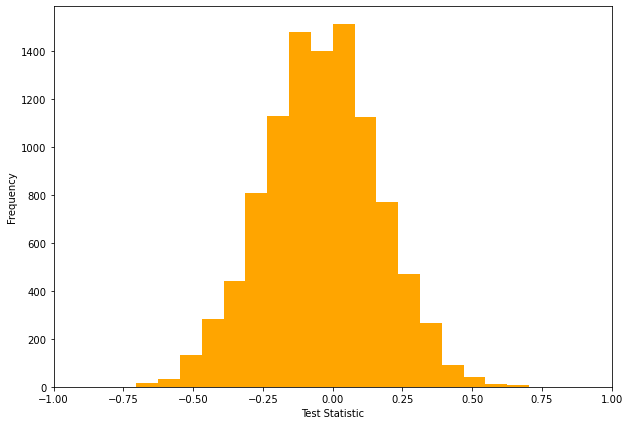

In [5]:
# Plot the distribution of test statistics for the 10,000 random permutations
plt.figure(figsize=(10,7))
plt.hist(score, bins = 18, color='orange')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.xlim(-1,1)
plt.show()
#plt.savefig('hist.png')

In [6]:
from scipy.stats import norm

# Calculate the Z-score
x=0.18681318681318687
zscore = (x - np.mean(score))/np.std(score)

# Print Z-score and P-value
print('Z-score =',zscore)
print('P-value =',1-norm.cdf(zscore))

Z-score = 1.165539507761649
P-value = 0.12190033891375629


There is not enough evidence to suggest that this string is significantly "hotter" than the population (*p*>0.05).

---
## Identifying shots following two makes or two misses

In [7]:
# Create new column 'follows_streak' that identifies shots following streaks of two makes or two misses
shot_df['follows_streak'] = shot_df.outcome.ne(shot_df['outcome'].shift())
shot_df['follows_streak'] = shot_df['follows_streak'].shift()
shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,True)
shot_df['follows_streak'] = ~shot_df['follows_streak']

# Intermediate columns to identify streaks of makes or misses
shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

# Create new columns 'follows_two_makes'
shot_df['follows_two_makes'] = shot_df.follows_streak == shot_df.new2
shot_df['follows_two_makes'] = shot_df['follows_two_makes'].astype(int)

# Create new columns 'follows_two_misses'
shot_df['follows_two_misses'] = shot_df.follows_streak ^ shot_df.new2
shot_df['follows_two_misses'] = shot_df['follows_two_misses'].astype(int)

# Drop intermediate columns
shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])

display(shot_df)

# Calculate conditional fraction of makes following two makes
if sum(shot_df['follows_two_makes'])>0:
    print(f"Following two makes: {sum(shot_df[shot_df['follows_two_makes']==1]['outcome'])} out of \
{sum(shot_df['follows_two_makes'])} ({round(sum(shot_df[shot_df['follows_two_makes']==1]['outcome'])/sum(shot_df['follows_two_makes']),4)*100}%)")
else:
    print('Following two makes: 0 out of 0 (0.0%)')

# Calculate conditional fraction of makes following two misses
if sum(shot_df['follows_two_makes'])>0:
    print(f"Following two misses: {sum(shot_df[shot_df['follows_two_misses']==1]['outcome'])} out of \
{sum(shot_df['follows_two_misses'])} ({round(sum(shot_df[shot_df['follows_two_misses']==1]['outcome'])/sum(shot_df['follows_two_misses']),4)*100}%)")    
else:
    print('Following two misses: 0 out of 0 (0.0%)')

# Subtract conditional fractions to give test statistic
print(f"Test statistic: \
{round(sum(shot_df[shot_df['follows_two_makes']==1]['outcome'])/sum(shot_df['follows_two_makes'])-sum(shot_df[shot_df['follows_two_misses']==1]['outcome'])/sum(shot_df['follows_two_misses']),4)*100}%")

,quarter,outcome,time_remaining_secs,follows_make,follows_two_makes,follows_two_misses
0,1,0,655,0,0,0
1,1,0,606,0,0,0
2,1,1,329,0,0,1
3,1,1,305,1,0,0
4,1,0,148,1,1,0
5,1,1,104,0,0,0
6,1,0,40,1,0,0
7,1,1,0,0,0,0
8,2,1,304,1,0,0
9,2,1,241,1,1,0


Following two makes: 5 out of 7 (71.43%)
Following two misses: 3 out of 8 (37.5%)
Test statistic: 33.93%


---
## Comparing this string to 10,000 random permutations of itself

In [9]:
# Placeholder list for test statistics
score = []

# Loop over the string 10,000 times, shuffle it, and calculate the test statistic each time
for i in range(10000):
    
    # Shuffle the string
    random.shuffle(outcome)

    # Put it in a dataframe
    shot_df = pd.DataFrame(data=outcome, columns=['outcome'])
    
    # Create new column 'follows_streak' that identifies shots following streaks of two makes or two misses
    shot_df['follows_streak'] = shot_df.outcome.ne(shot_df['outcome'].shift())
    shot_df['follows_streak'] = shot_df['follows_streak'].shift()
    shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,True)
    shot_df['follows_streak'] = ~shot_df['follows_streak']

    # Intermediate columns to identify streaks of makes or misses
    shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
    shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

    # Create new columns 'follows_two_makes'
    shot_df['follows_two_makes'] = shot_df.follows_streak == shot_df.new2
    shot_df['follows_two_makes'] = shot_df['follows_two_makes'].astype(int)

    # Create new columns 'follows_two_misses'
    shot_df['follows_two_misses'] = shot_df.follows_streak ^ shot_df.new2
    shot_df['follows_two_misses'] = shot_df['follows_two_misses'].astype(int)

    # Append test statistic to list
    score.append(sum(shot_df[shot_df['follows_two_makes']==1]['outcome'])/sum(shot_df['follows_two_makes'])-\
    sum(shot_df[shot_df['follows_two_misses']==1]['outcome'])/sum(shot_df['follows_two_misses']))

In [31]:
11/12

0.9166666666666666

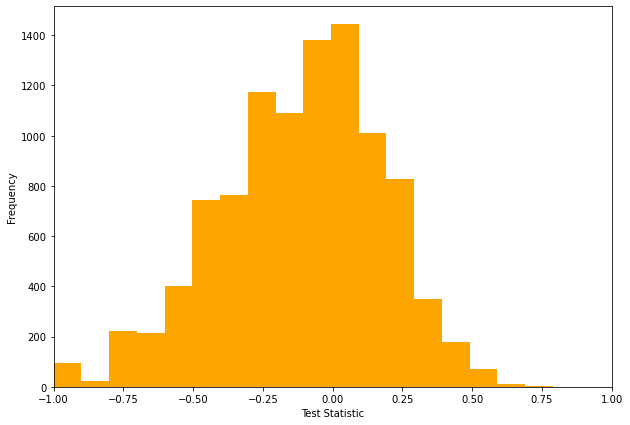

In [10]:
# Plot the distribution of test statistics for the 10,000 random permutations
plt.figure(figsize=(10,7))
plt.hist(score, bins = 18, color='orange')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.xlim(-1,1)
plt.show()
#plt.savefig('hist.png')

In [11]:
# Calculate the Z-score
x=0.3392857142857143
zscore = (x - np.mean(score))/np.std(score)

# Print Z-score and P-value
print('Z-score =',zscore)
print('P-value =',1-norm.cdf(zscore))

Z-score = 1.5675768646876098
P-value = 0.05848995742054319


There is not enough evidence to suggest that this string is significantly "hotter" than the population (*p*>0.05).

---
## Getting a list of all Warriors' games in the 2016-2017 season to loop over

In [12]:
# Send a get request and assign the response to a variable for a single team and season
response = requests.get('https://www.basketball-reference.com/teams/GSW/2017_games.html')
    
# Turn the undecoded content into a Beautiful Soup object and assign it to a variable
soup = BeautifulSoup(response.content, 'html.parser')

# Retrieve all tags that contain desired text and convert to string
href_tags = soup.find_all(href=True)
href_tags = [str(item) for item in href_tags]

# Store in dataframe
href_tags = pd.DataFrame(data=href_tags)

# Filter for boxscores only
searchfor = ['boxscores/2016','boxscores/2017']
href_tags = href_tags[href_tags[0].str.contains('|'.join(searchfor))].reset_index().drop(columns=['index'])

# Split string to get desired output
href_tags = href_tags[0].str.split("/",expand=True)
href_tags = href_tags[2].str.split(".html",expand=True).drop(columns=1)

# Convert array to list to loop through
games = href_tags[0].tolist()

In [13]:
# Check length of list
len(games)

99

--- 
## Retrieving the shot string and calculating the test statistic for every game Curry played in the 2016-2017 season

In [14]:
# Placeholder lists each games shot string and test statistics
shot_strings = []
scores = []
scores_2 = []

# Loop over the list of games
for game in games:
    
    # Send a get request and assign the response to a variable
    response = requests.get(f'https://www.basketball-reference.com/boxscores/shot-chart/{game}.html')
    
    # Turn the undecoded content into a Beautiful Soup object and assign it to a variable
    soup = BeautifulSoup(response.content, 'html.parser')  
    
    # Scrape makes and misses by quarter
    q1makes = soup.find_all(class_='tooltip q-1 p-curryst01 make')
    q1misses = soup.find_all(class_='tooltip q-1 p-curryst01 miss')
    q2makes = soup.find_all(class_='tooltip q-2 p-curryst01 make')
    q2misses = soup.find_all(class_='tooltip q-2 p-curryst01 miss')
    q3makes = soup.find_all(class_='tooltip q-3 p-curryst01 make')
    q3misses = soup.find_all(class_='tooltip q-3 p-curryst01 miss')
    q4makes = soup.find_all(class_='tooltip q-4 p-curryst01 make')
    q4misses = soup.find_all(class_='tooltip q-4 p-curryst01 miss')

    # Potential OT too
    q5makes = soup.find_all(class_='tooltip q-5 p-curryst01 make')
    q5misses = soup.find_all(class_='tooltip q-5 p-curryst01 miss')
    q6makes = soup.find_all(class_='tooltip q-6 p-curryst01 make')
    q6misses = soup.find_all(class_='tooltip q-6 p-curryst01 miss')

    # Add html from above to list and convert to string
    shot_list = list(q1makes+q2makes+q3makes+q4makes+q5makes+q6makes+q1misses+q2misses+q3misses+q4misses+q5misses+q6misses)
    shot_list = [str(item) for item in shot_list]
    
    # If list is empty, skip to next game...
    if not shot_list:
        pass
    
    # Otherwise, continue...
    else:
        
        # Store list in dataframe
        shot_df = pd.DataFrame(data=shot_list)

        # Expand string to form new columns
        shot_df = shot_df[0].str.split(" ",expand=True)

        # Select and name useful columns
        shot_df = shot_df.loc[:,(2,8,11)]
        shot_df.columns = ['quarter','time','outcome']
        
        # Format quarter as integer
        shot_df['quarter'] = shot_df['quarter'].str.slice(start=2).astype(int)

        # Separate time into component parts and total as 'time_remaining_secs'
        shot_df['minutes_remaining'] = shot_df['time'].str.split(":", expand=True).drop(columns=1).astype(int)
        shot_df['seconds_remaining'] = shot_df['time'].str.split(":", expand=True).drop(columns=0)
        shot_df['seconds_remaining'] = shot_df['seconds_remaining'].str.slice(stop=-2).astype(int)
        shot_df['time_remaining_secs'] = shot_df['minutes_remaining']*60+shot_df['seconds_remaining']
        shot_df = shot_df.drop(columns= ['time', 'minutes_remaining', 'seconds_remaining'])

        # Sort shots in ascending order
        shot_df = shot_df.sort_values(by=['quarter','time_remaining_secs'], ascending=[True, False]).reset_index().drop(columns=['index'])
        
        # Convert 'outcome' to binary
        shot_df['outcome'] = shot_df['outcome'].replace('made',1)
        shot_df['outcome'] = shot_df['outcome'].replace('missed',0).astype(int)
        
        # Convert 'outcome' to list
        outcome = shot_df['outcome'].to_list()
        
        # Append 'outcome' to list of shot strings for each game
        shot_strings.append(outcome)
        
        # Create new column 'follows_make' that identifies shots following a made shot
        shot_df['follows_make'] = shot_df['outcome'].shift()
        shot_df['follows_make'] = shot_df['follows_make'].replace(np.nan,0).astype(int)
        
        # Calculate conditional fraction of makes following makes
        if sum(shot_df['follows_make']) > 0:
            following_make = sum(shot_df[shot_df['follows_make']==1]['outcome'])/sum(shot_df['follows_make'])
        else:
            following_make = 0

        # Calculate conditional fraction of makes following misses
        if (len(shot_df['follows_make'])-sum(shot_df['follows_make'])-1) > 0:
            following_miss = sum(shot_df[shot_df['follows_make']==0]['outcome'][1:])/(len(shot_df['follows_make'])-sum(shot_df['follows_make'])-1)
        else:
            following_miss = 0
        
        # Subtract conditional fractions to give test statistic
        score_1 = following_make - following_miss
        
        # Append test statistic to list
        scores.append(score_1)
        
        # Create new column 'follows_streak' that identifies shots following streaks of two makes or two misses
        shot_df['follows_streak'] = shot_df.outcome.ne(shot_df['outcome'].shift())
        shot_df['follows_streak'] = shot_df['follows_streak'].shift()
        shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,True)
        shot_df['follows_streak'] = ~shot_df['follows_streak']

        # Intermediate columns to identify streaks of makes or misses
        shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
        shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

        # Create new columns 'follows_two_makes'
        shot_df['follows_two_makes'] = shot_df.follows_streak == shot_df.new2
        shot_df['follows_two_makes'] = shot_df['follows_two_makes'].astype(int)

        # Create new columns 'follows_two_misses'
        shot_df['follows_two_misses'] = shot_df.follows_streak ^ shot_df.new2
        shot_df['follows_two_misses'] = shot_df['follows_two_misses'].astype(int)

        # Calculate conditional fraction of makes following two makes
        if sum(shot_df['follows_two_makes']) > 0:  
            f_makes = sum(shot_df[shot_df['follows_two_makes']==1]['outcome'])/sum(shot_df['follows_two_makes'])
        else:
            f_makes = 0
        
        # Calculate conditional fraction of makes following two misses
        if sum(shot_df['follows_two_misses']) > 0:
            f_misses = sum(shot_df[shot_df['follows_two_misses']==1]['outcome'])/sum(shot_df['follows_two_misses'])
        else:
            f_misses = 0
            
        # Subtract conditional fractions to give test statistic
        score_2 = f_makes - f_misses
        
        # Append test statistic to list
        scores_2.append(score_2)

In [15]:
# Store lists in a dataframe
curry_2017 = pd.DataFrame(data=[shot_strings, scores, scores_2]).T
curry_2017.columns=['shot_string','test_stat','test_stat_2']
curry_2017

,shot_string,test_stat,test_stat_2
0,"[0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, ...",0.291667,0.266667
1,"[1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, ...",-0.25,-0.1
2,"[1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, ...",0.126984,-0.0666667
3,"[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, ...",0.0555556,-0.1
4,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0]",0.214286,-0.2
...,...,...,...
91,"[0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, ...",-0.3,-0.333333
92,"[1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1]",-0.388889,-0.5
93,"[0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, ...",0.207792,-0.0952381
94,"[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]",-0.178571,-0.333333


---
## Hypothesis testing each game in the 2016-2017 season

In [16]:
# Placeholder lists to append P-values
plist_1 = []
plist_2 = []

# Loop over the shot strings for every game
for index, string in enumerate(shot_strings):

    # Save current string to variable 'outcome'
    outcome = string
    
    # Placeholder lists each games and test statistics
    score = []
    score_2 = []
    
    # Loop over the string 10,000 times, shuffle it, and calculate the test statistic each time
    for i in range(10000):
        
        # Shuffle the string
        random.shuffle(outcome)

        # Put it in a dataframe
        shot_df = pd.DataFrame(data=outcome, columns=['outcome'])

        # Create new column 'follows_make' that identifies shots following a made shot
        shot_df['follows_make'] = shot_df['outcome'].shift()
        shot_df['follows_make'] = shot_df['follows_make'].replace(np.nan,0).astype(int)

        # Create new column 'follows_streak' that identifies shots following streaks of two makes or two misses
        shot_df['follows_streak'] = shot_df.outcome.ne(shot_df['outcome'].shift())
        shot_df['follows_streak'] = shot_df['follows_streak'].shift()
        shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,True)
        shot_df['follows_streak'] = ~shot_df['follows_streak']

        # Intermediate columns to identify streaks of makes or misses
        shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
        shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

        # Create new columns 'follows_two_makes'
        shot_df['follows_two_makes'] = shot_df.follows_streak == shot_df.new2
        shot_df['follows_two_makes'] = shot_df['follows_two_makes'].astype(int)

        # Create new columns 'follows_two_misses'
        shot_df['follows_two_misses'] = shot_df.follows_streak ^ shot_df.new2
        shot_df['follows_two_misses'] = shot_df['follows_two_misses'].astype(int)

        # Calculate conditional fraction of makes following makes
        if sum(shot_df['follows_make']) > 0:
            following_make = sum(shot_df[shot_df['follows_make']==1]['outcome'])/sum(shot_df['follows_make'])
        else:
            following_make = 0
        
        # Calculate conditional fractions of makes following misses
        following_miss = sum(shot_df[shot_df['follows_make']==0]['outcome'][1:])/(len(shot_df['follows_make'])-sum(shot_df['follows_make'])-1)

        # Append test statistic to list
        score.append(following_make - following_miss)

        # Calculate conditional fraction of makes following two makes
        if sum(shot_df['follows_two_makes']) > 0:
            f_makes = sum(shot_df[shot_df['follows_two_makes']==1]['outcome'])/sum(shot_df['follows_two_makes'])
        else:
            f_makes = 0

        # Calculate conditional fraction of makes following two misses
        if sum(shot_df['follows_two_misses']) > 0:
            f_misses = sum(shot_df[shot_df['follows_two_misses']==1]['outcome'])/sum(shot_df['follows_two_misses'])
        else:
            f_misses = 0
            
        # Append test statistic to list
        score_2.append(f_makes - f_misses)
    
    # Hypothesis test following one make or miss
    x=scores[index]
    zscore_1 = (x - np.mean(score))/np.std(score)
    p_1 = 1-norm.cdf(zscore_1)
    
    # Append P-value to list
    plist_1.append(p_1)

    # Hypothesis test following two makes or two misses
    x=scores_2[index]
    zscore_2 = (x - np.mean(score_2))/np.std(score_2)
    p_2 = 1-norm.cdf(zscore_2)
    
    # Append P-value to list
    plist_2.append(p_2)

In [17]:
# Add p_values to dataframe with strings and test statistics
curry_2017['p_value'] = plist_1
curry_2017['p_value_2'] = plist_2
curry_2017

,shot_string,test_stat,test_stat_2,p_value,p_value_2
0,"[1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, ...",0.291667,0.266667,0.078104,0.117931
1,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, ...",-0.25,-0.1,0.795755,0.398931
2,"[1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...",0.126984,-0.0666667,0.221395,0.357376
3,"[1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, ...",0.0555556,-0.1,0.313275,0.412091
4,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]",0.214286,-0.2,0.139739,0.425607
...,...,...,...,...,...
91,"[0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, ...",-0.3,-0.333333,0.868998,0.678504
92,"[0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1]",-0.388889,-0.5,0.895706,0.739599
93,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, ...",0.207792,-0.0952381,0.131347,0.393314
94,"[1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]",-0.178571,-0.333333,0.620768,0.509970


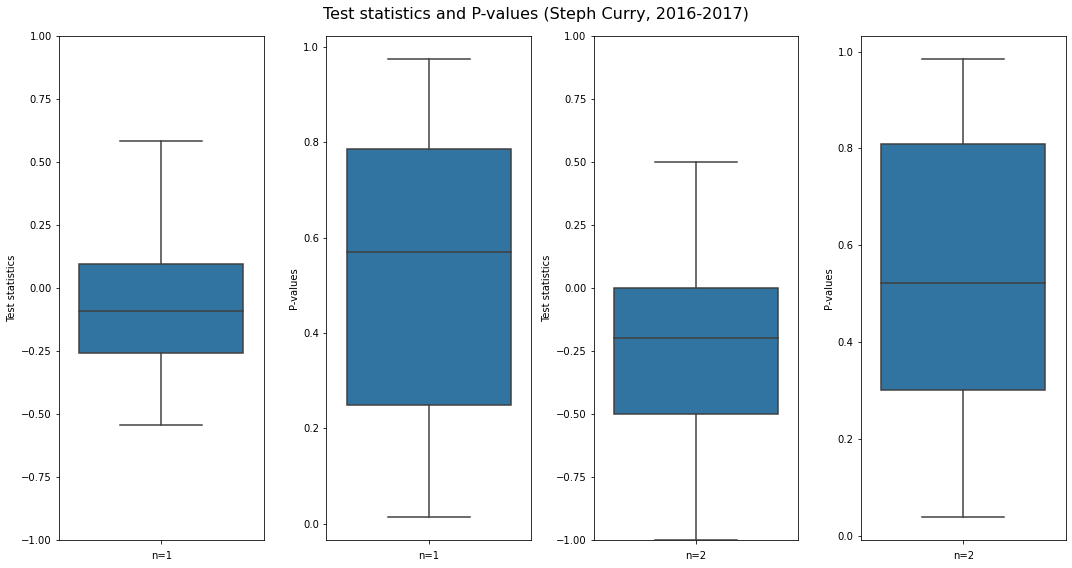

In [18]:
import seaborn as sns

# Boxplots of test statistics and p-values
plt.subplots(1,4, figsize=(15, 8))
plt.suptitle('Test statistics and P-values (Steph Curry, 2016-2017)', fontsize=16)

plt.subplot(1,4,1)
plt.xlabel('n=1')
plt.ylim(-1,1)
sns.boxplot(y=curry_2017['test_stat'])
plt.ylabel('Test statistics')

plt.subplot(1,4,3)
plt.xlabel('n=2')
plt.ylim(-1,1)
sns.boxplot(y=curry_2017['test_stat_2'])
plt.ylabel('Test statistics')

plt.subplot(1,4,2)
plt.xlabel('n=1')
sns.boxplot(y=curry_2017['p_value'])
plt.ylabel('P-values')

plt.subplot(1,4,4)
plt.xlabel('n=2')
sns.boxplot(y=curry_2017['p_value_2'])
plt.ylabel('P-values')

plt.tight_layout()
plt.show()

In [19]:
# Filtering for signifcant results, n=1
curry_2017[curry_2017['p_value']<0.05]

,shot_string,test_stat,test_stat_2,p_value,p_value_2
13,"[1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]",0.583333,0.466667,0.015138,0.067606
25,"[0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...",0.427273,0.339286,0.013986,0.071497
87,"[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, ...",0.328671,0.196429,0.036111,0.148620


In [20]:
# Filtering for signifcant results, n=2
curry_2017[curry_2017['p_value_2']<0.05]

,shot_string,test_stat,test_stat_2,p_value,p_value_2
39,"[1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, ...",0,0.5,0.402232,0.039135
50,"[0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1]",0.166667,0.5,0.202411,0.041872


Generally Curry's shooting percentage following makes was slightly lower than his shooting percentage following misses and very few observations demonstrated evidence (*p*<0.05) of a “hot hand” (only 3 observations out of 96 when *n*=1 and 2 observations out of 96 when *n*=2).

---
## Getting a list of all Warriors' games in the 2015-2016 season to loop over

In [21]:
# Send a get request and assign the response to a variable for a single team and season
response = requests.get('https://www.basketball-reference.com/teams/GSW/2016_games.html')
    
# Turn the undecoded content into a Beautiful Soup object and assign it to a variable
soup = BeautifulSoup(response.content, 'html.parser')

# Retrieve all tags that contain desired text and convert to string
href_tags = soup.find_all(href=True)
href_tags = [str(item) for item in href_tags]

# Store in dataframe
href_tags = pd.DataFrame(data=href_tags)

# Filter for boxscores only
searchfor = ['boxscores/2015','boxscores/2016']
href_tags = href_tags[href_tags[0].str.contains('|'.join(searchfor))].reset_index().drop(columns=['index'])

# Split string to get desired output
href_tags = href_tags[0].str.split("/",expand=True)
href_tags = href_tags[2].str.split(".html",expand=True).drop(columns=1)

# Convert array to list to loop through
games = href_tags[0].tolist()

In [22]:
# Check length of list
len(games)

106

--- 
## Retrieving the shot string and calculating the test statistic for every game Curry played in the 2015-2016 season

In [23]:
# Placeholder lists each games shot string and test statistics
shot_strings = []
scores = []
scores_2 = []

# Loop over the list of games
for game in games:
    
    # Send a get request and assign the response to a variable
    response = requests.get(f'https://www.basketball-reference.com/boxscores/shot-chart/{game}.html')
    
    # Turn the undecoded content into a Beautiful Soup object and assign it to a variable
    soup = BeautifulSoup(response.content, 'html.parser')  
    
    # Scrape makes and misses by quarter
    q1makes = soup.find_all(class_='tooltip q-1 p-curryst01 make')
    q1misses = soup.find_all(class_='tooltip q-1 p-curryst01 miss')
    q2makes = soup.find_all(class_='tooltip q-2 p-curryst01 make')
    q2misses = soup.find_all(class_='tooltip q-2 p-curryst01 miss')
    q3makes = soup.find_all(class_='tooltip q-3 p-curryst01 make')
    q3misses = soup.find_all(class_='tooltip q-3 p-curryst01 miss')
    q4makes = soup.find_all(class_='tooltip q-4 p-curryst01 make')
    q4misses = soup.find_all(class_='tooltip q-4 p-curryst01 miss')

    # Potential OT too
    q5makes = soup.find_all(class_='tooltip q-5 p-curryst01 make')
    q5misses = soup.find_all(class_='tooltip q-5 p-curryst01 miss')
    q6makes = soup.find_all(class_='tooltip q-6 p-curryst01 make')
    q6misses = soup.find_all(class_='tooltip q-6 p-curryst01 miss')

    # Add html from above to list and convert to string
    shot_list = list(q1makes+q2makes+q3makes+q4makes+q5makes+q6makes+q1misses+q2misses+q3misses+q4misses+q5misses+q6misses)
    shot_list = [str(item) for item in shot_list]
    
    # If list is empty, skip to next game...
    if not shot_list:
        pass
    
    # Otherwise, continue...
    else:
        
        # Store list in dataframe
        shot_df = pd.DataFrame(data=shot_list)

        # Expand string to form new columns
        shot_df = shot_df[0].str.split(" ",expand=True)

        # Select and name useful columns
        shot_df = shot_df.loc[:,(2,8,11)]
        shot_df.columns = ['quarter','time','outcome']
        
        # Format quarter as integer
        shot_df['quarter'] = shot_df['quarter'].str.slice(start=2).astype(int)

        # Separate time into component parts and total as 'time_remaining_secs'
        shot_df['minutes_remaining'] = shot_df['time'].str.split(":", expand=True).drop(columns=1).astype(int)
        shot_df['seconds_remaining'] = shot_df['time'].str.split(":", expand=True).drop(columns=0)
        shot_df['seconds_remaining'] = shot_df['seconds_remaining'].str.slice(stop=-2).astype(int)
        shot_df['time_remaining_secs'] = shot_df['minutes_remaining']*60+shot_df['seconds_remaining']
        shot_df = shot_df.drop(columns= ['time', 'minutes_remaining', 'seconds_remaining'])

        # Sort shots in ascending order
        shot_df = shot_df.sort_values(by=['quarter','time_remaining_secs'], ascending=[True, False]).reset_index().drop(columns=['index'])
        
        # Convert 'outcome' to binary
        shot_df['outcome'] = shot_df['outcome'].replace('made',1)
        shot_df['outcome'] = shot_df['outcome'].replace('missed',0).astype(int)
        
        # Convert 'outcome' to list
        outcome = shot_df['outcome'].to_list()
        
        # Append 'outcome' to list of shot strings for each game
        shot_strings.append(outcome)
        
        # Create new column 'follows_make' that identifies shots following a made shot
        shot_df['follows_make'] = shot_df['outcome'].shift()
        shot_df['follows_make'] = shot_df['follows_make'].replace(np.nan,0).astype(int)
        
        # Calculate conditional fraction of makes following makes
        if sum(shot_df['follows_make']) > 0:
            following_make = sum(shot_df[shot_df['follows_make']==1]['outcome'])/sum(shot_df['follows_make'])
        else:
            following_make = 0

        # Calculate conditional fraction of makes following misses
        if (len(shot_df['follows_make'])-sum(shot_df['follows_make'])-1) > 0:
            following_miss = sum(shot_df[shot_df['follows_make']==0]['outcome'][1:])/(len(shot_df['follows_make'])-sum(shot_df['follows_make'])-1)
        else:
            following_miss = 0
        
        # Subtract conditional fractions to give test statistic
        score_1 = following_make - following_miss
        
        # Append test statistic to list
        scores.append(score_1)
        
        # Create new column 'follows_streak' that identifies shots following streaks of two makes or two misses
        shot_df['follows_streak'] = shot_df.outcome.ne(shot_df['outcome'].shift())
        shot_df['follows_streak'] = shot_df['follows_streak'].shift()
        shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,True)
        shot_df['follows_streak'] = ~shot_df['follows_streak']

        # Intermediate columns to identify streaks of makes or misses
        shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
        shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

        # Create new columns 'follows_two_makes'
        shot_df['follows_two_makes'] = shot_df.follows_streak == shot_df.new2
        shot_df['follows_two_makes'] = shot_df['follows_two_makes'].astype(int)

        # Create new columns 'follows_two_misses'
        shot_df['follows_two_misses'] = shot_df.follows_streak ^ shot_df.new2
        shot_df['follows_two_misses'] = shot_df['follows_two_misses'].astype(int)

        # Calculate conditional fraction of makes following two makes
        if sum(shot_df['follows_two_makes']) > 0:  
            f_makes = sum(shot_df[shot_df['follows_two_makes']==1]['outcome'])/sum(shot_df['follows_two_makes'])
        else:
            f_makes = 0
        
        # Calculate conditional fraction of makes following two misses
        if sum(shot_df['follows_two_misses']) > 0:
            f_misses = sum(shot_df[shot_df['follows_two_misses']==1]['outcome'])/sum(shot_df['follows_two_misses'])
        else:
            f_misses = 0
            
        # Subtract conditional fractions to give test statistic
        score_2 = f_makes - f_misses
        
        # Append test statistic to list
        scores_2.append(score_2)

In [24]:
# Store lists in a dataframe
curry_2016 = pd.DataFrame(data=[shot_strings, scores, scores_2]).T
curry_2016.columns=['shot_string','test_stat','test_stat_2']
curry_2016

,shot_string,test_stat,test_stat_2
0,"[1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, ...",0.116883,-0.175
1,"[0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0]",0.0666667,0
2,"[1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, ...",-0.0784314,-0.4
3,"[1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]",0.444444,0.416667
4,"[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...",0.238095,0
...,...,...,...
92,"[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1]",-0.171429,0.666667
93,"[0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...",-0.1,-0.380952
94,"[1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...",-0.166667,-0.5
95,"[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...",-0.0795455,0


---
## Hypothesis testing each game in the 2015-2016 season

In [25]:
# Placeholder lists to append P-values
plist_1 = []
plist_2 = []

# Loop over the shot strings for every game
for index, string in enumerate(shot_strings):

    # Save current string to variable 'outcome'
    outcome = string
    
    # Placeholder lists each games and test statistics
    score = []
    score_2 = []
    
    # Loop over the string 10,000 times, shuffle it, and calculate the test statistic each time
    for i in range(10000):
        
        # Shuffle the string
        random.shuffle(outcome)

        # Put it in a dataframe
        shot_df = pd.DataFrame(data=outcome, columns=['outcome'])

        # Create new column 'follows_make' that identifies shots following a made shot
        shot_df['follows_make'] = shot_df['outcome'].shift()
        shot_df['follows_make'] = shot_df['follows_make'].replace(np.nan,0).astype(int)

        # Create new column 'follows_streak' that identifies shots following streaks of two makes or two misses
        shot_df['follows_streak'] = shot_df.outcome.ne(shot_df['outcome'].shift())
        shot_df['follows_streak'] = shot_df['follows_streak'].shift()
        shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,True)
        shot_df['follows_streak'] = ~shot_df['follows_streak']

        # Intermediate columns to identify streaks of makes or misses
        shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
        shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

        # Create new columns 'follows_two_makes'
        shot_df['follows_two_makes'] = shot_df.follows_streak == shot_df.new2
        shot_df['follows_two_makes'] = shot_df['follows_two_makes'].astype(int)

        # Create new columns 'follows_two_misses'
        shot_df['follows_two_misses'] = shot_df.follows_streak ^ shot_df.new2
        shot_df['follows_two_misses'] = shot_df['follows_two_misses'].astype(int)

        # Calculate conditional fraction of makes following makes
        if sum(shot_df['follows_make']) > 0:
            following_make = sum(shot_df[shot_df['follows_make']==1]['outcome'])/sum(shot_df['follows_make'])
        else:
            following_make = 0
        
        # Calculate conditional fractions of makes following misses
        following_miss = sum(shot_df[shot_df['follows_make']==0]['outcome'][1:])/(len(shot_df['follows_make'])-sum(shot_df['follows_make'])-1)

        # Append test statistic to list
        score.append(following_make - following_miss)

        # Calculate conditional fraction of makes following two makes
        if sum(shot_df['follows_two_makes']) > 0:
            f_makes = sum(shot_df[shot_df['follows_two_makes']==1]['outcome'])/sum(shot_df['follows_two_makes'])
        else:
            f_makes = 0

        # Calculate conditional fraction of makes following two misses
        if sum(shot_df['follows_two_misses']) > 0:
            f_misses = sum(shot_df[shot_df['follows_two_misses']==1]['outcome'])/sum(shot_df['follows_two_misses'])
        else:
            f_misses = 0
            
        # Append test statistic to list
        score_2.append(f_makes - f_misses)
    
    # Hypothesis test following one make or miss
    x=scores[index]
    zscore_1 = (x - np.mean(score))/np.std(score)
    p_1 = 1-norm.cdf(zscore_1)
    
    # Append P-value to list
    plist_1.append(p_1)

    # Hypothesis test following two makes or two misses
    x=scores_2[index]
    zscore_2 = (x - np.mean(score_2))/np.std(score_2)
    p_2 = 1-norm.cdf(zscore_2)
    
    # Append P-value to list
    plist_2.append(p_2)

In [26]:
# Add p_values to dataframe with strings and test statistics
curry_2016['p_value'] = plist_1
curry_2016['p_value_2'] = plist_2
curry_2016

,shot_string,test_stat,test_stat_2,p_value,p_value_2
0,"[1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...",0.116883,-0.175,0.214979,0.553137
1,"[1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0]",0.0666667,0,0.303349,0.316629
2,"[1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, ...",-0.0784314,-0.4,0.574005,0.809425
3,"[1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]",0.444444,0.416667,0.022328,0.076499
4,"[0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, ...",0.238095,0,0.118928,0.301197
...,...,...,...,...,...
92,"[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1]",-0.171429,0.666667,0.620278,0.018948
93,"[0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, ...",-0.1,-0.380952,0.611566,0.774727
94,"[1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, ...",-0.166667,-0.5,0.699462,0.820013
95,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, ...",-0.0795455,0,0.550869,0.302806


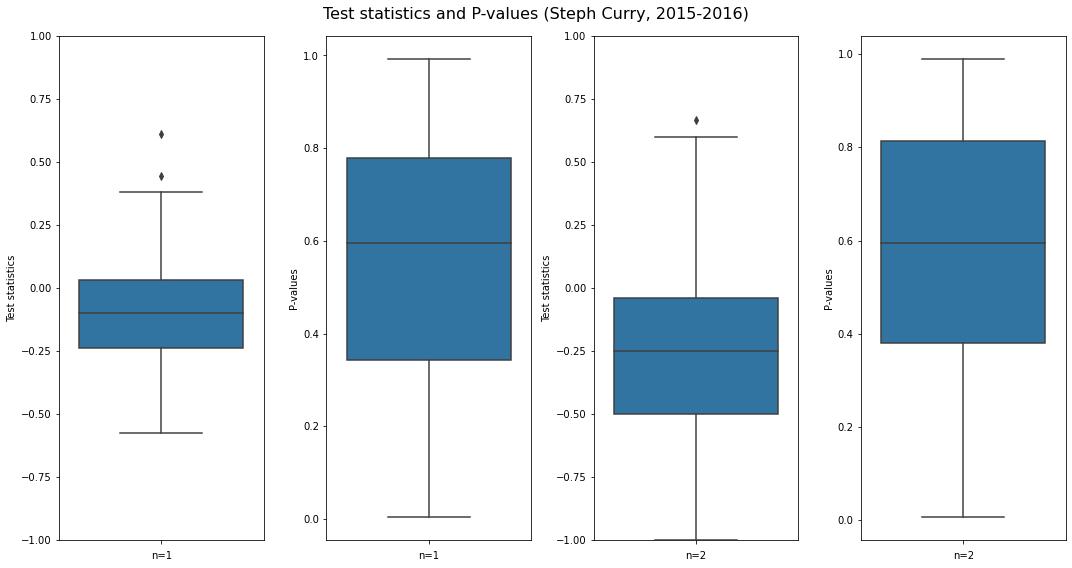

In [27]:
# Boxplots of test statistics and p-values
plt.subplots(1,4, figsize=(15, 8))
plt.suptitle('Test statistics and P-values (Steph Curry, 2015-2016)', fontsize=16)

plt.subplot(1,4,1)
plt.xlabel('n=1')
plt.ylim(-1,1)
sns.boxplot(y=curry_2016['test_stat'])
plt.ylabel('Test statistics')

plt.subplot(1,4,3)
plt.xlabel('n=2')
plt.ylim(-1,1)
sns.boxplot(y=curry_2016['test_stat_2'])
plt.ylabel('Test statistics')

plt.subplot(1,4,2)
plt.xlabel('n=1')
sns.boxplot(y=curry_2016['p_value'])
plt.ylabel('P-values')

plt.subplot(1,4,4)
plt.xlabel('n=2')
sns.boxplot(y=curry_2016['p_value_2'])
plt.ylabel('P-values')

plt.tight_layout()
plt.show()

In [28]:
# Filtering for signifcant results, n=1
curry_2016[curry_2016['p_value']<0.05]

,shot_string,test_stat,test_stat_2,p_value,p_value_2
3,"[1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]",0.444444,0.416667,0.022328,0.076499
29,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1]",0.611111,0.514286,0.004258,0.032269
46,"[1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, ...",0.333333,0.169231,0.025878,0.182060
70,"[1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, ...",0.352273,0.125,0.038821,0.198957


In [29]:
# Filtering for signifcant results, n=2
curry_2016[curry_2016['p_value_2']<0.05]

,shot_string,test_stat,test_stat_2,p_value,p_value_2
29,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1]",0.611111,0.514286,0.004258,0.032269
43,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]",0.380952,0.6,0.060551,0.007139
48,"[0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, ...",0.0454545,0.433333,0.339891,0.038098
52,"[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...",-0.571429,0.5,0.992184,0.032103
92,"[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1]",-0.171429,0.666667,0.620278,0.018948


Again his shooting percentage following makes was slightly lower than his shooting percentage following misses. Slightly more observations demonstrated evidence (*p*<0.05) of a “hot hand” in 2015-2016 but it was still relatively few (4 observations out of 97 when *n*=1 and 5 observations out of 97 when *n*=2).

---